In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.signal as scsig
import spectrum as sp
import signale
import cPickle as pkl
import time
import statsmodels.api as sm
import colormaps as cm
import seaborn as sns
import signale.tools as tools
import os
import trajectory
from sklearn.cluster import KMeans
from matplotlib.mlab import specgram
import matplotlib.mlab as mlab

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
-

In [5]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/LinearTrack_12-24-15_Day4/'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3839Control/dataFiles/sleepDB/'
localPath = '/mnt/Data/ephysdata/Rats/'

In [6]:
lfpPaths = []
for lfp in tools.locate('*-p*.lfp',animalPath):#animalPath):
    lfpPaths.append(os.path.join(lfp[0],lfp[1]))
lfpPaths = sorted(lfpPaths)
nvtPaths = []
for nvt in tools.locate('*.nvt',animalPath):
    nvtPaths.append(os.path.join(nvt[0],nvt[1]))
nvtPaths = sorted(nvtPaths)
nvtPaths = np.array(nvtPaths)

In [20]:
plotit = 0
for iii,nvtFile in enumerate(nvtPaths[[0,2]]):
    ####Loading trajectory data
    print nvtFile
    ts = np.array(nvt_loader(nvtFile)['qTimeStamps']/1e3)
    x  = np.array(nvt_loader(nvtFile)['dnextracted_x'])
    y  = np.array(nvt_loader(nvtFile)['dnextracted_y'])
    a  = np.array(nvt_loader(nvtFile)['dnextracted_angle'])
    r = np.sqrt(np.power(x,2)+np.power(y,2))
    #### Fixing invalid position data points
    OrigIdx = np.where(r==0)[0]
    for idx in OrigIdx:
        r[idx] = r[idx-1]+r[idx+1]/2.0
    ###Determining the moving average of position and head direction
    rma = MA(r,ord=50)
    ama = MA(a,ord=10)
    ###Determining imoobility periods("true" sleep periods!!!)
    cond1 = pd.rolling_std(rma,50) < 0.7
    cond2 = pd.rolling_std(ama,10) < 5.5
    for cond in [cond1,cond2]:
        chIdx = np.where(pd.rolling_std(cond,2)>0)[0]
        kk = 0
        while kk <chIdx.size:
            initIdx =  chIdx[kk-1]
            finIdx =   chIdx[kk]
            if finIdx - initIdx < 300 and finIdx-initIdx > 0:
                cond[initIdx:finIdx] = np.ones(finIdx-initIdx)
            kk+=2
    cnd = np.logical_and(cond1,cond2)
    ####Extracting long spans of immobility!
    sleepList = []
    chIdx = np.where(pd.rolling_std(cnd,2)>0)[0]
    if cnd[chIdx[0]-1]:
        if chIdx[0] > 150:
            sleepList.append(ts[0],ts[chIdx[0]])
            kk = 1
    else:
        kk = 0
    while kk < len(chIdx)-1:
        try:
            if  chIdx[kk+1] - chIdx[kk]> 150:
                sleepList.append([ts[chIdx[kk]],ts[chIdx[kk+1]]])
            kk+=2 
        except ValueError:
            print kk
            kk +=2
    sleepList = np.array(sleepList)
    ####Loading LFP and computing the spectrogram
    lfp = pkl.load(open(lfpPaths[iii],'rb'))
    print lfp.tags['file']
    pathSplit = lfp.tags['file'].split('/')
    datecnd = np.array(['LinearTrack' in item for item in pathSplit])
    sessioncnd = np.array(['-sleep' in item for item in pathSplit])
    date =  np.array(pathSplit)[datecnd][0].split('_')[-1]
    print date
    Pxx = np.zeros([39,1])
    SleepTimeIndex = []
    chunkEndIdx = []
    cEIdx = 0
    for item in sleepList[:]:
        ii,ti =  signale.tools.findNearest(lfp.timeAxis,item[0])
        ff,tf =  signale.tools.findNearest(lfp.timeAxis,item[1])
        immoChunkLFP = lfp.signal[ii:ff]
        if immoChunkLFP.size: 
            print ti,tf
            t,frq,p = mySpecgram(immoChunkLFP,minFreq=0.1,maxFreq=20,windowSize=2048,
                               method='yule',Fs=2000,overlap=1024,NFFT=4096)
            cEIdx += p.shape[1]
            chunkEndIdx.append(cEIdx)
            SleepTimeIndex.append([ti,tf,t.size])
            Pxx = np.append(Pxx,p,axis=1)
    Pxx = np.delete(Pxx,0,1) #delete the first column of zeros!
    SleepTimeIndex = pd.DataFrame(SleepTimeIndex,columns=['initTime','finTime','pxx-time'])
    if not iii:
        SleepTimeIndex.to_pickle(dataFolder+'ImmPeriods-'+date+'-01pre.db')
        pkl.dump(Pxx,open(dataFolder+'Pxx-'+date+'-01pre.pkl','wb'),pkl.HIGHEST_PROTOCOL)
    else:
        SleepTimeIndex.to_pickle(dataFolder+'ImmPeriods-'+date+'-03post.db')
        pkl.dump(Pxx,open(dataFolder+'Pxx-'+date+'-03post.pkl','wb'),pkl.HIGHEST_PROTOCOL)
    #print SleepTimeIndex
    if plotit:
        f,ax = pl.subplots(3,1,figsize=[30,10],sharex=True)
        ax[0].plot(ts,zScore(a),alpha=0.2,lw=1)
        ax[0].scatter(ts[cond2],zScore(ama)[cond2],marker='*',c='g')
        ax[0].set_yticks([])
        ax[0].set_ylabel(r'Head direction($rad$)',fontsize=20)
        ax[1].plot(ts,zScore(r),alpha=0.2,lw=1)
        ax[1].scatter(ts[cond1],zScore(rma)[cond1],marker='*',c='c')
        ax[1].set_yticks([])
        ax[1].set_ylabel(r'$r = \sqrt{x^2+y^2}$',fontsize=20)
        ax[2].plot(ts,zScore(r),alpha=0.2,lw=1)
        ax[2].scatter(ts[cnd],zScore(rma[cnd]),marker='*',c='r')
        ax[2].set_xlabel('Time (S)',fontsize=24)
        #ax[2].set_xlim(ts[10000],ts[25000])
        ax[2].set_yticks([])
        ax[2].set_ylabel(r'$r = \sqrt{x^2+y^2}$',fontsize=20)
        ax[2].set_xticks([1500,2500,3500,4500])
        ax[2].set_xticklabels([1000,2000,3000,4000],fontsize=14)
        for item in sleepList:
            ax[2].axvspan(item[0],item[1],alpha=0.5,color='r')
        ax[2].plot(lfp.timeAxis,lfp.signal,lw=1,alpha=0.7)


/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/LinearTrack_12-24-15_Day4/01-sleep1/VT1.nvt
/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/LinearTrack_12-24-15_Day4/01-sleep1/CSC1.ncs
Day4
1453621.09 1466366.59
1525525.09 1699066.09
1710411.09 1944111.09
1954186.59 2370703.59
2410477.09 2507442.09
2523091.09 2550950.59
2563062.59 2586287.09
2601734.59 2868234.59
2878244.09 3083883.59
3095192.59 3237772.09
3250950.59 3284854.09
3305840.59 3427593.59
3471106.09 3489623.59
3505471.59 3598098.09
3614881.09 3645645.59
3657525.09 3718251.59
3730963.59 4221655.09
4248782.09 4261394.59
4279478.59 4929163.09
4949216.09 4957892.09
4974207.09 4997630.59
5008074.09 5022255.09
5033132.59 5064864.59
/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/LinearTrack_12-24-15_Day4/03-sleep2/VT1.nvt
/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3839/LinearTrack_12-24-15_Day4/03-sleep2/CSC1.ncs
Day4
7379812.747 7407440.247
7434601.247 7634367.247
7646412.247 80

119

In [7]:
fig,ax = pl.subplots(1,1,figsize=[30,10])
for idx,row in SleepTimeIndex.iterrows():
    ax.axvspan((row.initTime),(row.initTime + row.duration),ymin=0.88,ymax=0.98,alpha=0.305)
ax.plot(lfp.timeAxis,lfp.signal,lw=1)
for ii,row in SleepPeriodsDF[SleepPeriodsDF['epoch']=='sws'].iterrows():
    pl.axvspan(row.t0,row.t1,ymin=0.8,ymax=0.9,color='k',alpha=0.35)
for ii,row in SleepPeriodsDF[SleepPeriodsDF['epoch']=='rem'].iterrows():
    pl.axvspan(row.t0,row.t1,color='r',ymin=0.72,ymax=0.82,alpha=0.35)

NameError: name 'SleepPeriodsDF' is not defined

In [ ]:
Dmean = frq[frq<5].mean()
Tmean = frq[np.logical_and(frq>6,frq<12)].mean()
Gmean = frq[frq>12].mean()
Dbounds = np.where(frq<5)[0][[0,-1]]
Tbounds = np.where(np.logical_and(frq>6,frq<12))[0][[0,-1]]
Gbounds = np.where(frq>12)[0][[0,-1]]
DavgPwr = Pxx[Dbounds[0]:Dbounds[-1]+1,:].mean(axis=0)
TavgPwr = Pxx[Tbounds[0]:Tbounds[-1]+1,:].mean(axis=0)
GavgPwr = Pxx[Gbounds[0]:Gbounds[-1]+1,:].mean(axis=0)
DpwrNormal = DavgPwr*(Dmean/Gmean)
TpwrNormal = TavgPwr*(Tmean/Gmean)

In [21]:
pwrData = np.array([DpwrNormal,TpwrNormal,GavgPwr]).T
Klusters = KMeans(n_clusters=2).fit_predict(pwrData)
k2 = Klusters.copy()

In [22]:
UpIdx   = np.where(Klusters==1)[0]
DownIdx = np.where(Klusters==0)[0]

if UpIdx.size > DownIdx.size:
    SinularIdx = np.where(np.diff(DownIdx)==2)[0]
    SinularIdx  = np.int32(DownIdx[SinularIdx]  + np.ones(SinularIdx.size))
    np.put(Klusters,SinularIdx,np.zeros(SinularIdx.size))
    SecondFlip =False
else:
    SinularIdx = np.where(np.diff(UpIdx)==2)[0]
    SinularIdx  = np.int32(UpIdx[SinularIdx]  + np.ones(SinularIdx.size))
    np.put(Klusters,SinularIdx,np.ones(SinularIdx.size))
    SecondFlip =True
if SecondFlip:
    SinularIdx = np.where(np.diff(DownIdx)==2)[0]
    SinularIdx  = np.int32(DownIdx[SinularIdx]  + np.ones(SinularIdx.size))
    np.put(Klusters,SinularIdx,np.zeros(SinularIdx.size))
else:
    SinularIdx = np.where(np.diff(UpIdx)==2)[0]
    SinularIdx  = np.int32(UpIdx[SinularIdx]  + np.ones(SinularIdx.size))
    np.put(Klusters,SinularIdx,np.ones(SinularIdx.size))
###########222#######
###
###########222#######
K1ratio = (DpwrNormal[Klusters==1] / TpwrNormal[Klusters==1]).mean()
K0ratio = (DpwrNormal[Klusters==0] / TpwrNormal[Klusters==0]).mean()
if K1ratio<K0ratio:
    print 'Cluster labels fliped!!!'
    Klusters = np.int8(np.logical_not(Klusters))
k1 = Klusters.copy()
###
# from now on SWS episodes are Kluster ==1
###
swsIdx = np.where(Klusters==1)[0]
dupletIdx = np.where(np.diff(swsIdx)==3)[0]
dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
####Repeat the same procedure for REM
remIdx = np.where(Klusters==0)[0]
dupletIdx = np.where(np.diff(remIdx)==3)[0]
dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx1st,np.zeros(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.zeros(dupletIdx2nd.size))
##########333############
###Now chunks of length 3!
##########333############
swsIdx = np.where(Klusters==1)[0]
dupletIdx = np.where(np.diff(swsIdx)==4)[0]
dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
####Repeat the same procedure for REM
remIdx = np.where(Klusters==0)[0]
dupletIdx = np.where(np.diff(remIdx)==4)[0]
dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
try:
    dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
except IndexError:
    print 'It\'s a bit marginal!'
np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
##########444############
###Now chunks of length 4!
##########444############
swsIdx = np.where(Klusters==1)[0]
dupletIdx = np.where(np.diff(swsIdx)==5)[0]
dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
dupletIdx4th = np.int32(swsIdx[dupletIdx] +4* np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
np.put(Klusters,dupletIdx4th,np.ones(dupletIdx4th.size))
####Repeat the same procedure for REM
remIdx = np.where(Klusters==0)[0]
dupletIdx = np.where(np.diff(remIdx)==5)[0]
dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
try:
    dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
    dupletIdx3rd = np.int32(swsIdx[dupletIdx] +4* np.ones(dupletIdx.size))
except IndexError:
    print 'It\'s a bit marginal!'
np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
np.put(Klusters,dupletIdx4th,np.ones(dupletIdx4th.size))

In [23]:
UpIdx   = np.where(Klusters==1)[0]
DownIdx = np.where(Klusters==0)[0]
SingletIdxU = np.where(np.diff(DownIdx)==2)[0]
SingletIdxD = np.where(np.diff(UpIdx)  ==2)[0]
while SingletIdxU.size or SingletIdxD.size:
    print SingletIdxU.size,SingletIdxD.size
    if UpIdx.size > DownIdx.size:
        SingletIdxU = np.int32(DownIdx[SingletIdxU]  + np.ones(SingletIdxU.size))
        np.put(Klusters,SingletIdxU,np.zeros(SingletIdxU.size))
        SecondFlip =False
    else:
        SingletIdxD = np.where(np.diff(UpIdx)==2)[0]
        SingletIdxD  = np.int32(UpIdx[SingletIdxD]  + np.ones(SingletIdxD.size))
        np.put(Klusters,SingletIdxD,np.ones(SingletIdxD.size))
        SecondFlip =True
    if SecondFlip:
        SingletIdxU = np.where(np.diff(DownIdx)==2)[0]
        SingletIdxU  = np.int32(DownIdx[SingletIdxU]  + np.ones(SingletIdxU.size))
        np.put(Klusters,SingletIdxU,np.zeros(SingletIdxU.size))
    else:
        SingletIdxD = np.where(np.diff(UpIdx)==2)[0]
        SingletIdxD  = np.int32(UpIdx[SingletIdxD]  + np.ones(SingletIdxD.size))
        np.put(Klusters,SingletIdxD,np.ones(SingletIdxD.size))
    del SecondFlip
    ###########222#######
    ###
    ###########222#######
    K1ratio = (DpwrNormal[Klusters==1] / TpwrNormal[Klusters==1]).mean()
    K0ratio = (DpwrNormal[Klusters==0] / TpwrNormal[Klusters==0]).mean()
    if K1ratio<K0ratio:
        print 'Cluster labels fliped!!!'
        Klusters = np.int8(np.logical_not(Klusters))
    k1 = Klusters.copy()
    ###
    # from now on SWS episodes are Kluster ==1
    ###
    swsIdx = np.where(Klusters==1)[0]
    dupletIdx = np.where(np.diff(swsIdx)==3)[0]
    dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
    dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
    ####Repeat the same procedure for REM
    remIdx = np.where(Klusters==0)[0]
    dupletIdx = np.where(np.diff(remIdx)==3)[0]
    dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
    dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx1st,np.zeros(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.zeros(dupletIdx2nd.size))
    ##########333############
    ###Now chunks of length 3!
    ##########333############
    swsIdx = np.where(Klusters==1)[0]
    dupletIdx = np.where(np.diff(swsIdx)==4)[0]
    dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
    dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
    np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
    ####Repeat the same procedure for REM
    remIdx = np.where(Klusters==0)[0]
    dupletIdx = np.where(np.diff(remIdx)==4)[0]
    dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
    try:
        dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
        dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
    except IndexError:
        print 'It\'s a bit marginal!'
    np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
    np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
    ##########444############
    ###Now chunks of length 4!
    ##########444############
    swsIdx = np.where(Klusters==1)[0]
    dupletIdx = np.where(np.diff(swsIdx)==5)[0]
    dupletIdx1st = np.int32(swsIdx[dupletIdx] + np.ones(dupletIdx.size))
    dupletIdx2nd = np.int32(swsIdx[dupletIdx] +2* np.ones(dupletIdx.size))
    dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
    dupletIdx4th = np.int32(swsIdx[dupletIdx] +4* np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
    np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
    np.put(Klusters,dupletIdx4th,np.ones(dupletIdx4th.size))
    ####Repeat the same procedure for REM
    remIdx = np.where(Klusters==0)[0]
    dupletIdx = np.where(np.diff(remIdx)==5)[0]
    dupletIdx1st = np.int32(remIdx[dupletIdx] + np.ones(dupletIdx.size))
    try:
        dupletIdx2nd = np.int32(remIdx[dupletIdx] +2* np.ones(dupletIdx.size))
        dupletIdx3rd = np.int32(swsIdx[dupletIdx] +3* np.ones(dupletIdx.size))
        dupletIdx4th = np.int32(swsIdx[dupletIdx] +4* np.ones(dupletIdx.size))
    except IndexError:
        print 'It\'s a bit marginal!'
    np.put(Klusters,dupletIdx1st,np.ones(dupletIdx.size))
    np.put(Klusters,dupletIdx2nd,np.ones(dupletIdx2nd.size))
    np.put(Klusters,dupletIdx3rd,np.ones(dupletIdx3rd.size))
    np.put(Klusters,dupletIdx4th,np.ones(dupletIdx4th.size))
            
    UpIdx   = np.where(Klusters==1)[0]
    DownIdx = np.where(Klusters==0)[0]
    SingletIdxU = np.where(np.diff(DownIdx)==2)[0]
    SingletIdxD = np.where(np.diff(UpIdx)  ==2)[0]

0 1


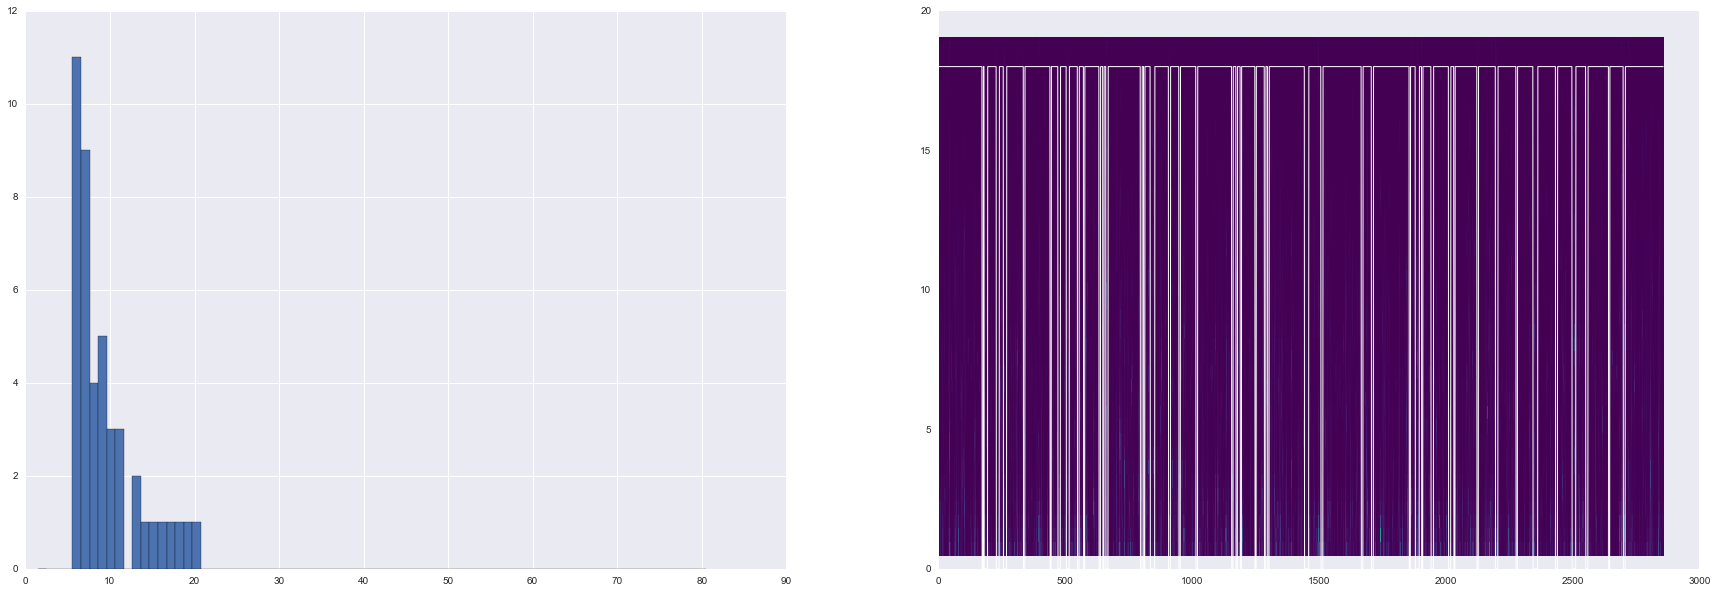

In [72]:
fig,(ax,bx) = pl.subplots(1,2,figsize=[30,10])
bx.pcolormesh(range(Pxx.shape[1]),frq,Pxx,cmap=cm.viridis)
bx.plot(Klusters*18,'w',lw=1)
ax.hist(np.diff(np.where(Klusters==1)[0]),np.linspace(1.5,80.5,79));

In [24]:
-

44 44


In [73]:
pkl.dump(swsPeriods,open('swsPeriods.pkl','wb'))
pkl.dump(remPeriods,open('remPeriods.pkl','wb'))

/home/chenani/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


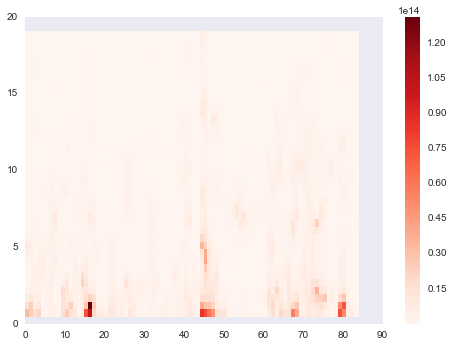

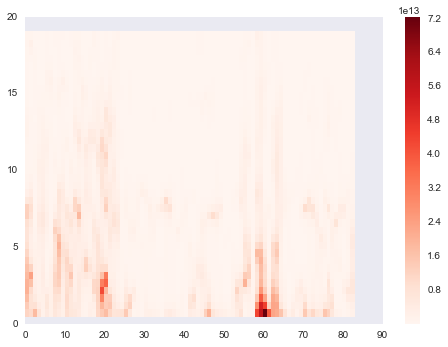

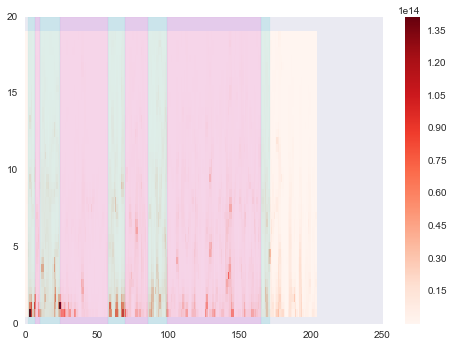

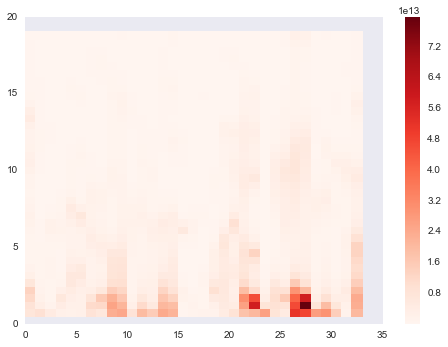

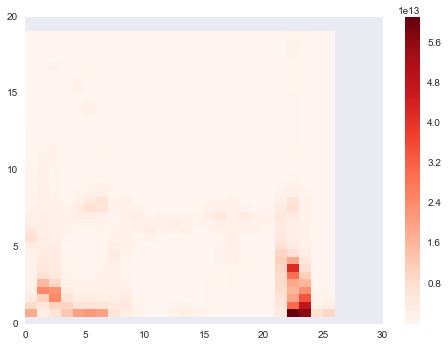

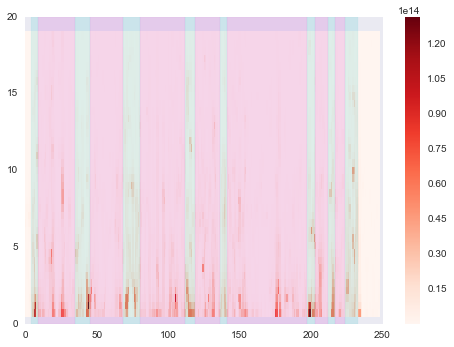

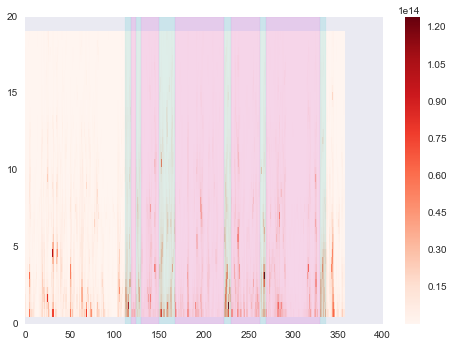

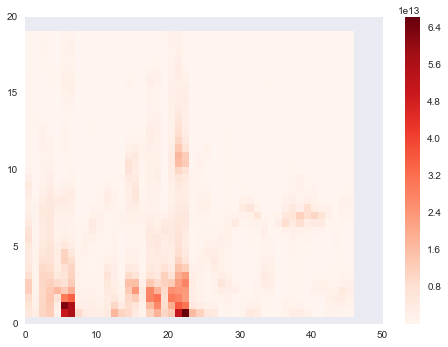

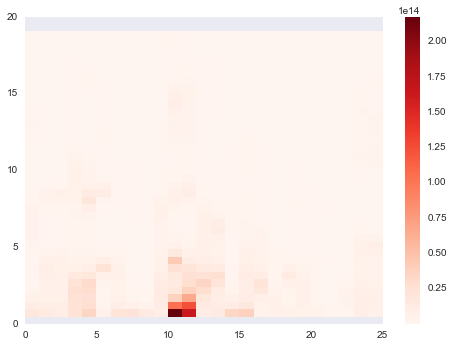

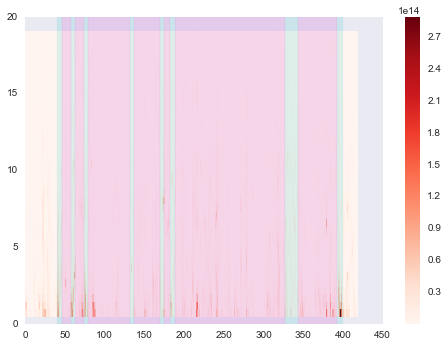

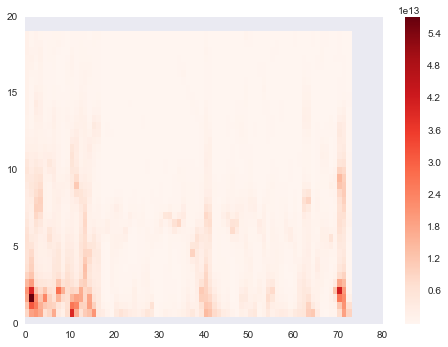

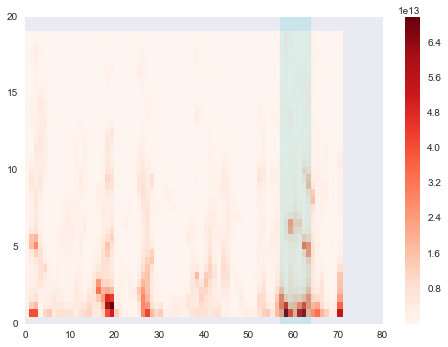

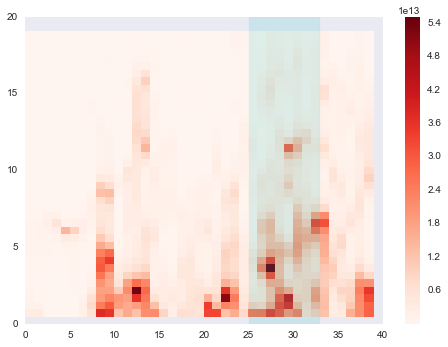

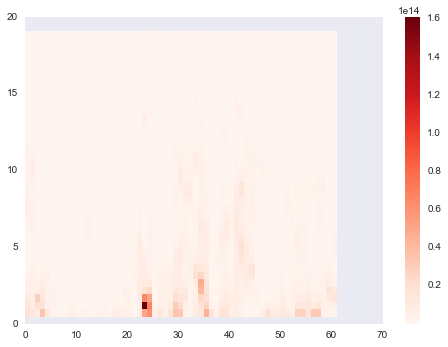

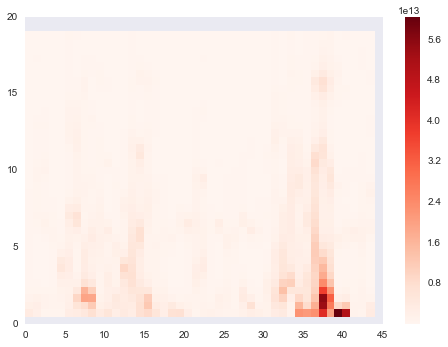

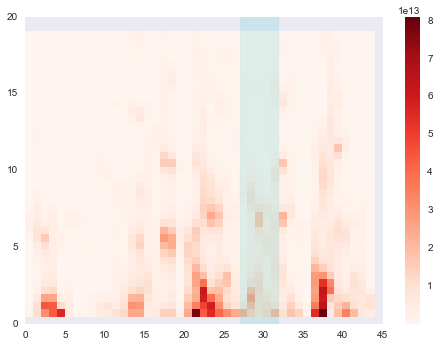

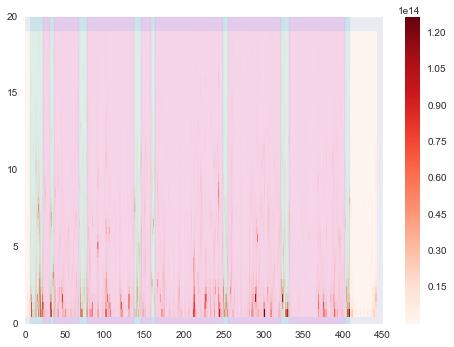

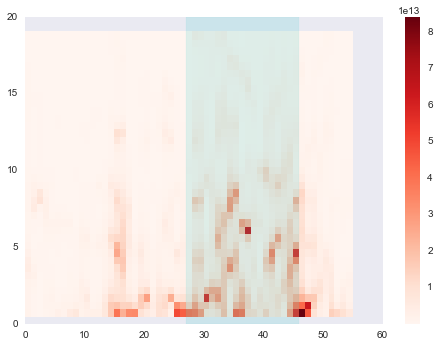

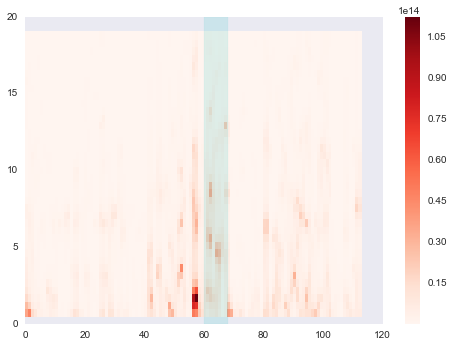

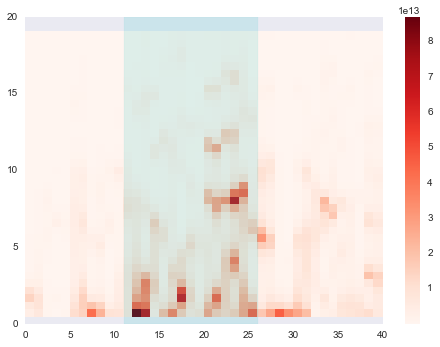

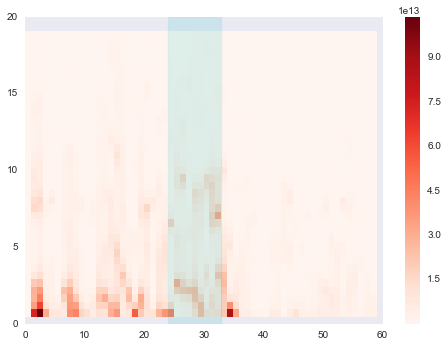

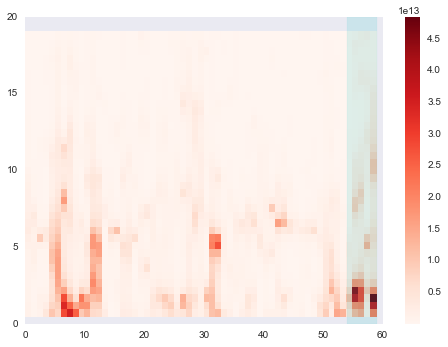

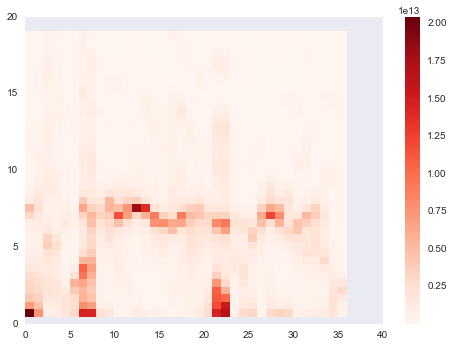

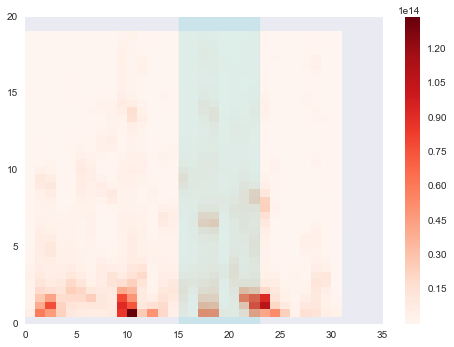

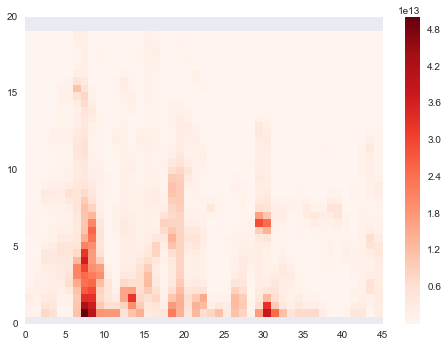

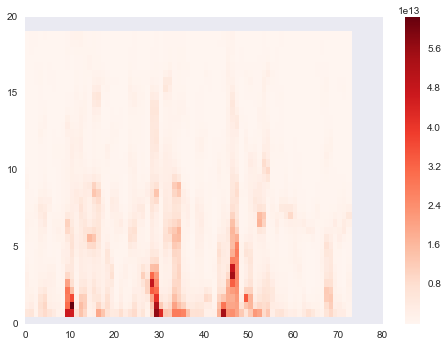

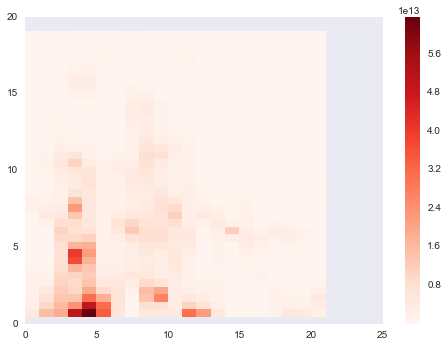

In [37]:
ksum = 0
for ii,tidx in enumerate(SleepTimeIndex.durationSeconds):
    fig,ax = pl.subplots(1,1)
    validSWSepisodes = np.where(np.logical_and(swsPeriods[:,0]>ksum,
                                               swsPeriods[:,1]<ksum+tidx))[0]
    validREMepisodes = np.where(np.logical_and(remPeriods[:,0]>ksum,
                                               remPeriods[:,1]<ksum+tidx))[0]
    #print validSWSepisodes
    t,freqs = np.meshgrid(np.arange(tidx),frq)
    im = ax.pcolormesh(t,freqs,Pxx[:,ksum:ksum+tidx],cmap='Reds')
    for item in validSWSepisodes:
        ax.axvspan(swsPeriods[item,0]-ksum,swsPeriods[item,1]-ksum,alpha=0.13,color='m',label='SWS')
    for item in validREMepisodes:
        ax.axvspan(remPeriods[item,0]-ksum,remPeriods[item,1]-ksum,alpha=0.13,color='c',label='REM')
    #pl.legend()
    pl.colorbar(im)
    ksum += tidx

In [40]:
SleepTimeIndex

,initTime,duration,durationSeconds
0,11023880.134,6205.0,13
1,11701890.134,5274.0,11
2,11763585.634,6473.0,13
3,12151874.134,8076.5,16
4,12295818.634,5572.0,11
5,12677530.134,6576.5,13
6,12716040.134,6872.0,14
7,12738861.134,6840.5,14
8,12809732.634,6941.5,14
9,13091146.634,6440.0,13


## SleepPeriodDF

In [90]:
timeConversionFactor = (SleepTimeIndex.duration/SleepTimeIndex.durationSeconds).mean()
ksum = 0
pathSplit = lfp.tags['file'].split('/')
animalcnd = np.array(['Rat' in item for item in pathSplit])
datecnd = np.array(['LinearTrack' in item for item in pathSplit])
sessioncnd = np.array(['-sleep' in item for item in pathSplit])
animal =  np.array(pathSplit)[animalcnd][0]
date =  np.array(pathSplit)[datecnd][0].split('_')[1]
session = np.array(pathSplit)[sessioncnd][0].split('-')[-1]
print session,date,animal
###First Sleep period and initiating Dataframe
strSWSepisodes1 = np.where(np.logical_and(swsPeriods[:,0]>ksum,
                                           swsPeriods[:,0]<ksum+
                                           SleepTimeIndex.durationSeconds[0]))[0]
strSWSepisodes2 = np.where(swsPeriods[:,1]>ksum+SleepTimeIndex.durationSeconds[0])[0]
startsInSWS =  np.intersect1d(strSWSepisodes1,strSWSepisodes2)

endSWSepisodes1 = np.where(np.logical_and(swsPeriods[:,1]>ksum,
                                           swsPeriods[:,1]<ksum+
                                           SleepTimeIndex.durationSeconds[0]))[0]
endSWSepisodes2 = np.where(swsPeriods[:,0]<ksum)[0]
endsInSWS =  np.intersect1d(endSWSepisodes1,endSWSepisodes2)
validSWSepisodes = np.where(np.logical_and(swsPeriods[:,0]>ksum,
                                           swsPeriods[:,1]<ksum+
                                           SleepTimeIndex.durationSeconds[0]))[0]
#####################################################################################################
strREMepisodes1 = np.where(np.logical_and(remPeriods[:,0]>ksum,
                                           remPeriods[:,0]<ksum+
                                           SleepTimeIndex.durationSeconds[0]))[0]
strREMepisodes2 = np.where(remPeriods[:,1]>ksum+SleepTimeIndex.durationSeconds[0])[0]
startsInREM =  np.intersect1d(strREMepisodes1,strREMepisodes2)

endREMepisodes1 = np.where(np.logical_and(remPeriods[:,1]>ksum,
                                          remPeriods[:,1]<ksum+
                                          SleepTimeIndex.durationSeconds[0]))[0]
endREMepisodes2 = np.where(remPeriods[:,0]<ksum)[0]
endsInREM =  np.intersect1d(endREMepisodes1,endREMepisodes2)
validREMepisodes = np.where(np.logical_and(remPeriods[:,0]>ksum,
                                           remPeriods[:,1]<ksum+
                                           SleepTimeIndex.durationSeconds[0]))[0]
SleepPeriodsDF = pd.DataFrame([[SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[0,0]-ksum),
                                SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[0,1]-ksum),
                                'sws',session,date,animal]],
                              columns=['t0','t1','epoch','session','date','animal'])
for item in validSWSepisodes[1:]:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[item,0]-ksum),
                       SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[item,1]-ksum),
                       'sws',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
    
for item in startsInSWS:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[item,0]-ksum),
                       SleepTimeIndex.initTime[0] + timeConversionFactor*SleepTimeIndex.durationSeconds[0],
                       'sws',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
for item in endsInSWS:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0],
                       SleepTimeIndex.initTime[0] + timeConversionFactor*(swsPeriods[item,1]-ksum),
                       'sws',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
for item in validREMepisodes:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0] + timeConversionFactor*(remPeriods[item,0]-ksum),
                       SleepTimeIndex.initTime[0] + timeConversionFactor*(remPeriods[item,1]-ksum),
                       'rem',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
for item in startsInREM:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0] + timeConversionFactor*(remPeriods[item,0]-ksum),
                       SleepTimeIndex.initTime[0] + SleepTimeIndex.duration[0],
                       'rem',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
for item in endsInREM:
    df =pd.DataFrame([[SleepTimeIndex.initTime[0],
                       SleepTimeIndex.initTime[0] + timeConversionFactor*(remPeriods[item,1]-ksum),
                       'rem',session,date,animal]],
                       columns=['t0','t1','epoch','session','date','animal'])
    SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
    del df
#print ksum
ksum += SleepTimeIndex.durationSeconds[0]
print startsInSWS
print endsInSWS
print validSWSepisodes
print startsInREM
print endsInREM
print validREMepisodes
for ii in SleepTimeIndex.index[1:]:
    #fig,ax = pl.subplots(1,1)
    strSWSepisodes1 = np.where(np.logical_and(swsPeriods[:,0]>ksum,
                                              swsPeriods[:,0]<ksum+
                                              SleepTimeIndex.durationSeconds[ii]))[0]
    strSWSepisodes2 = np.where(swsPeriods[:,1]>ksum+SleepTimeIndex.durationSeconds[ii])[0]
    startsInSWS =  np.intersect1d(strSWSepisodes1,strSWSepisodes2)

    endSWSepisodes1 = np.where(np.logical_and(swsPeriods[:,1]>ksum,
                                              swsPeriods[:,1]<ksum+
                                              SleepTimeIndex.durationSeconds[ii]))[0]
    endSWSepisodes2 = np.where(swsPeriods[:,0]<ksum)[0]
    endsInSWS =  np.intersect1d(endSWSepisodes1,endSWSepisodes2)
    validSWSepisodes = np.where(np.logical_and(swsPeriods[:,0]>ksum,
                                               swsPeriods[:,1]<ksum+
                                               SleepTimeIndex.durationSeconds[ii]))[0]
    
    
    for item in validSWSepisodes[1:]:
        #print item,(swsPeriods[item,0]-ksum)
        df =pd.DataFrame([[SleepTimeIndex.initTime[ii] + timeConversionFactor*(swsPeriods[item,0]-ksum),
                           SleepTimeIndex.initTime[ii] + timeConversionFactor*(swsPeriods[item,1]-ksum),
                           'sws',session,date,animal]],
                           columns=['t0','t1','epoch','session','date','animal'])
        SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
        del df
    for item in startsInSWS:
        df =pd.DataFrame([[SleepTimeIndex.initTime[ii] + timeConversionFactor*(swsPeriods[item,0]-ksum),
                           SleepTimeIndex.initTime[ii] + timeConversionFactor*SleepTimeIndex.durationSeconds[ii],
                           'sws',session,date,animal]],
                           columns=['t0','t1','epoch','session','date','animal'])
        SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
        del df
    for item in endsInSWS:
        df =pd.DataFrame([[SleepTimeIndex.initTime[ii],
                           SleepTimeIndex.initTime[ii] + timeConversionFactor*(swsPeriods[item,1]-ksum),
                           'sws',session,date,animal]],
                           columns=['t0','t1','epoch','session','date','animal'])
        SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
        del df
    ######################################################################################
    strREMepisodes1 = np.where(np.logical_and(remPeriods[:,0]>ksum,
                                              remPeriods[:,0]<ksum+
                                              SleepTimeIndex.durationSeconds[ii]))[0]
    strREMepisodes2 = np.where(remPeriods[:,1]>=ksum+SleepTimeIndex.durationSeconds[ii])[0]
    startsInREM =  np.intersect1d(strREMepisodes1,strREMepisodes2)

    endREMepisodes1 = np.where(np.logical_and(remPeriods[:,1]>ksum,
                                              remPeriods[:,1]<ksum+
                                              SleepTimeIndex.durationSeconds[ii]))[0]
    endREMepisodes2 = np.where(remPeriods[:,0]<=ksum)[0]
    endsInREM =  np.intersect1d(endREMepisodes1,endREMepisodes2)
    validREMepisodes = np.where(np.logical_and(remPeriods[:,0]>ksum,
                                               remPeriods[:,1]<ksum+
                                               SleepTimeIndex.durationSeconds[ii]))[0]
    for item in validREMepisodes:
        df =pd.DataFrame([[SleepTimeIndex.initTime[ii] + timeConversionFactor*(remPeriods[item,0]-ksum),
                           SleepTimeIndex.initTime[ii] + timeConversionFactor*(remPeriods[item,1]-ksum),
                           'rem',session,date,animal]],
                           columns=['t0','t1','epoch','session','date','animal'])
        SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
        del df
    for item in startsInREM:
        df =pd.DataFrame([[SleepTimeIndex.initTime[ii] + timeConversionFactor*(remPeriods[item,0]-ksum),
                           SleepTimeIndex.initTime[ii] + timeConversionFactor*SleepTimeIndex.durationSeconds[ii],
                           'rem',session,date,animal]],
                           columns=['t0','t1','epoch','session','date','animal'])
        SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
        del df
    for item in endsInREM:
            df =pd.DataFrame([[SleepTimeIndex.initTime[ii],
                               SleepTimeIndex.initTime[ii] + timeConversionFactor*(remPeriods[item,1]-ksum),
                               'rem',session,date,animal]],
                               columns=['t0','t1','epoch','session','date','animal'])
            SleepPeriodsDF = SleepPeriodsDF.append(df, ignore_index=True)
            del df
    #for item in validREMepisodes:
    #    ax.axvspan(remPeriods[item,0]-ksum,remPeriods[item,1]-ksum,alpha=0.13,color='c')
    print 'stSWS',startsInSWS
    print 'endSWS',endsInSWS
    print startsInREM
    print endsInREM
    print validSWSepisodes
    print validREMepisodes                         
    print '--------------------------------'
    ksum += SleepTimeIndex.durationSeconds[ii]

sleep1 12-22-15 Rat3839
[]
[]
[]
[]
[]
[]
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS [5]
endSWS [0]
[]
[]
[1 2 3 4]
[0 1 2 3 4]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS [13]
endSWS [5]
[]
[]
[ 6  7  8  9 10 11 12]
[ 5  6  7  8  9 10 11 12]
--------------------------------
stSWS [19]
endSWS [13]
[]
[]
[14 15 16 17 18]
[13 14 15 16 17 18]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS [27]
endSWS [19]
[]
[]
[20 21 22 23 24 25 26]
[19 20 21 22 23 24 25 26]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
--------------------------------
stSWS [28]
endSWS [27]
[]
[]
[]
[27]
--------------------------------
stSWS [29]
endSWS [28]
[]
[]
[]
[28]
--------------------------------
stSWS []
endSWS []
[]
[]
[]
[]
-

In [55]:
swsIdx = SleepPeriodsDF[SleepPeriodsDF['epoch']=='sws'].index
remIdx = SleepPeriodsDF[SleepPeriodsDF['epoch']=='rem'].index
pl.hist([(SleepPeriodsDF.t1 - SleepPeriodsDF.t0)[swsIdx],
         (SleepPeriodsDF.t1 - SleepPeriodsDF.t0)[remIdx]])

([array([ 19.,  16.,   3.,  10.,   2.,   1.,   1.,   0.,   1.,   1.]),
  array([ 42.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([   1000.,   18000.,   35000.,   52000.,   69000.,   86000.,
         103000.,  120000.,  137000.,  154000.,  171000.]),
 <a list of 2 Lists of Patches objects>)

In [145]:
for tt in SleepPeriodsDF.t0:
    if np.where(SleepPeriodsDF.t0==tt)[0].size>1:
        print tt,np.where(SleepPeriodsDF.t0==tt)[0].size

1310532.603 2
1310532.603 2


In [35]:
pd.to_pickle(SleepPeriodsDF,'sleep1Periods.pd')

In [33]:
psd = np.array([])
dates = []
sessions = []
animals = []
state = []
freqz = []
epN = 0
epochNo = []
for path in lfpPaths[:]:
    pickedChannel = pkl.load(open(path,'rb'))
    NFFT = int(2 ** 17)
    expDate = path.split('_')[0].split('/')[-1]
    session = path.split('_')[-2]
    session = session[:-1]+'0'+session[-1]
    relevantEpochs = SleepEpochsEven[np.logical_and(SleepEpochsEven['date']== expDate,
                                                SleepEpochsEven['session']==session)]
    relevantEpochs.index = range(relevantEpochs.index.size)
    Nepochs = relevantEpochs.shape[0]
    print expDate,session
    if Nepochs:
        print Nepochs
        print relevantEpochs
        for kk in range(Nepochs):
            t0 = relevantEpochs.t0[kk]
            tf = relevantEpochs.t1[kk]
            sigSlice = np.logical_and(pickedChannel.time_axis()>t0*1e3,pickedChannel.time_axis()<tf*1e3)
            dsig = scsig.decimate(pickedChannel.signal[sigSlice],2)
            arma = sm.tsa.ARMA(dsig,(2,0)).fit(disp=0)
            residPSD = sp.Periodogram(arma.resid,sampling=1000,NFFT=NFFT)
            residPSD()
            Nfreqz = residPSD.psd.size
            smoothingKernel = scsig.gaussian(Nfreqz/100,Nfreqz/200)
            residPSDSmooth = np.convolve(residPSD.psd,smoothingKernel,'same')
            residPSDSmooth = scsig.decimate(residPSDSmooth,10)
            psd = np.append(psd,residPSDSmooth)
            freqz.append(scsig.decimate(residPSD.frequencies(),10))
            dates.append(residPSDSmooth.size*[relevantEpochs.date[0]])
            sessions.append(residPSDSmooth.size*[relevantEpochs.session[0]])
            animals.append(residPSDSmooth.size*[relevantEpochs.animal[0]])
            state.append(residPSDSmooth.size*[relevantEpochs.epoch[kk]])
            epochNo.append(residPSDSmooth.size*[epN])
            epN+=1
animals = np.array(animals).flatten()
dates = np.array(dates).flatten()
sessions = np.array(sessions).flatten()
state = np.array(state).flatten()
freqz = np.array(freqz).flatten()
epochNo = np.array(epochNo).flatten()
dfm = np.array([psd,freqz,state,epochNo,sessions,dates,animals]).T
df = pd.DataFrame(dfm,columns=['psd','f','epoch','epochNo','session','date','animal'])
df[['psd', 'f']] = df[['psd', 'f']].astype(float)
df[['epochNo']] = df[['epochNo']].astype(int)
df[['epoch','session','date','animal']] = df[['epoch','session','date','animal']].astype(str)

MECLesion /home/chenani/dataWork/ali/MECLesio0n
MECLesion /home/chenani/dataWork/ali/MECLesio0n


In [34]:
freqBins = np.linspace(0.5,300.5,600)
psd = np.array([])
dates = []
sessions = []
animals = []
state = []
freqz = []
epN = 0
epochNo = []
for path in lfpPaths[:]:
    pickedChannel = pkl.load(open(path,'rb'))
    expDate = path.split('_')[0].split('/')[-1]
    session = path.split('_')[-2]
    session = session[:-1]+'0'+session[-1]
    relevantEpochs = SleepEpochs[np.logical_and(SleepEpochs['date']== expDate,
                                                SleepEpochs['session']==session)]
    relevantEpochs.index = range(relevantEpochs.index.size)
    Nepochs = relevantEpochs.shape[0]
    print expDate,session
    if Nepochs:
        #print Nepochs
        #print relevantEpochs
        for kk in range(Nepochs):
            t0 = relevantEpochs.t0[kk]
            tf = relevantEpochs.t1[kk]
            sigSlice = np.logical_and(pickedChannel.time_axis()>t0*1e3,pickedChannel.time_axis()<tf*1e3)
            dsig = scsig.decimate(pickedChannel.signal[sigSlice],2)
            NFFT = int(2**(np.floor(np.log2(dsig.size))+1))
            arma = sm.tsa.ARMA(dsig,(2,0)).fit(disp=0)
            residPSD = sp.Periodogram(arma.resid,sampling=1000,NFFT=NFFT)
            residPSD()
            Nfreqz = residPSD.psd.size
            hst,freqBins = np.histogram(residPSD.frequencies(),bins=freqBins)
            avgPSD = np.zeros(hst.size)
            idx = 0
            for ii,item in enumerate(hst):
                avgPSD[ii] = residPSD.psd[idx:idx+item].mean()
                idx+=item
            Imax = avgPSD.argmax()
            avgPSD[Imax] = (avgPSD[Imax-1] + avgPSD[Imax+1])/2.0
            #avgPSD = np.convolve(avgPSD,scsig.gaussian(freqBins.size/30,freqBins.size/60),'same')
            psd = np.append(psd,avgPSD)
            freqz.append(np.arange(1,300.5,0.5))
            dates.append(avgPSD.size*[relevantEpochs.date[0]])
            sessions.append(avgPSD.size*[relevantEpochs.session[0]])
            animals.append(avgPSD.size*[relevantEpochs.animal[0]])
            state.append(avgPSD.size*[relevantEpochs.epoch[kk]])
            epochNo.append(avgPSD.size*[epN])
            epN+=1
animals = np.array(animals).flatten()
dates = np.array(dates).flatten()
sessions = np.array(sessions).flatten()
state = np.array(state).flatten()
freqz = np.array(freqz).flatten()
epochNo = np.array(epochNo).flatten()
dfm = np.array([psd,freqz,state,epochNo,sessions,dates,animals]).T
df = pd.DataFrame(dfm,columns=['psd','f','epoch','epochNo','session','date','animal'])
df[['psd', 'f']] = df[['psd', 'f']].astype(float)
df[['epochNo']] = df[['epochNo']].astype(int)
df[['epoch','session','date','animal']] = df[['epoch','session','date','animal']].astype(str)

MECLesion /home/chenani/dataWork/ali/MECLesio0n
MECLesion /home/chenani/dataWork/ali/MECLesio0n
